# 기본과제: DistilBERT로 뉴스 기사 분류 모델 학습하기

In [ ]:
!pip install tqdm boto3 requests regex sentencepiece sacremoses datasets

[MYCDOE] 로그 기능 추가
- 데이터를 확인하기 위해 로그를 통해 데이터를 출력

In [ ]:
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader
import logging as log
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd


for handler in log.root.handlers[:]:
        log.root.removeHandler(handler)

log.basicConfig(
    level= log.INFO,
)
device = 'cuda'
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'distilbert-base-uncased')

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main


In [ ]:
log.info(f"tokenizer={tokenizer}")

INFO:root:tokenizer=DistilBertTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)


In [ ]:
ds = load_dataset("fancyzhx/ag_news")


In [ ]:

tokenizer(ds['train']['text'][:2], padding=True, truncation=False)

{'input_ids': [[101, 2813, 2358, 1012, 6468, 15020, 2067, 2046, 1996, 2304, 1006, 26665, 1007, 26665, 1011, 2460, 1011, 19041, 1010, 2813, 2395, 1005, 1055, 1040, 11101, 2989, 1032, 2316, 1997, 11087, 1011, 22330, 8713, 2015, 1010, 2024, 3773, 2665, 2153, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 18431, 2571, 3504, 2646, 3293, 13395, 1006, 26665, 1007, 26665, 1011, 2797, 5211, 3813, 18431, 2571, 2177, 1010, 1032, 2029, 2038, 1037, 5891, 2005, 2437, 2092, 1011, 22313, 1998, 5681, 1032, 6801, 3248, 1999, 1996, 3639, 3068, 1010, 2038, 5168, 2872, 1032, 2049, 29475, 2006, 2178, 2112, 1997, 1996, 3006, 1012, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

[MYCODE] dataset features 확인하기

In [ ]:
log.info(f"{ds['test'].features['label']}")

INFO:root:ClassLabel(names=['World', 'Sports', 'Business', 'Sci/Tech'], id=None)


[MYCODE] AG_News dataset 준비
- Truncation 삭제 -> False 변경한다.

In [ ]:
def collate_fn(batch):

  texts, labels = [], []
  for row in batch:
    labels.append(row['label'])
    texts.append(row['text'])
  token = tokenizer(texts, padding=True, truncation=False)
  texts = torch.LongTensor(token.input_ids)
  attention_mask = torch.LongTensor(token.attention_mask)
  labels = torch.LongTensor(labels)

  return texts, attention_mask, labels


train_loader = DataLoader(
    ds['train'], batch_size=64, shuffle=True, collate_fn=collate_fn
)

test_loader = DataLoader(
    ds['test'], batch_size=64, shuffle=False, collate_fn=collate_fn
)

In [ ]:
# length = []
# for text, labels in train_loader.dataset['text']:
#     length.append(len(text))

# max(length)

ValueError: too many values to unpack (expected 2)

In [ ]:
len(train_loader)
log.info(f"last dataset [text]  word : {train_loader.dataset['text'][119999]}")
log.info(f"last dataset [label] word : {train_loader.dataset['label'][119999]}")

# 라벨별 빈도 계산
label_counts = Counter(train_loader.dataset['label'])

# DataFrame 생성
label_df = pd.DataFrame(list(label_counts.items()), columns=["Label", "Count"])

# 라벨 이름 추가 (예: AG News 라벨은 0, 1, 2, 3으로 구성됨)
label_names = ["World", "Sports", "Business", "Sci/Tech"]
label_df["Label Name"] = [label_names[label] for label in label_df["Label"]]

log.info(label_df)

INFO:root:last dataset [text]  word : Nets get Carter from Raptors INDIANAPOLIS -- All-Star Vince Carter was traded by the Toronto Raptors to the New Jersey Nets for Alonzo Mourning, Eric Williams, Aaron Williams, and a pair of first-round draft picks yesterday.
INFO:root:last dataset [label] word : 1
INFO:root:   Label  Count Label Name
0      2  30000   Business
1      3  30000   Sci/Tech
2      1  30000     Sports
3      0  30000      World


[MYCODE] vocab 데이터 확인

In [ ]:
vocab = tokenizer.vocab
vocab_size = len(vocab)
log.info(f"vocab :{vocab}")
log.info(f"vocab size : {vocab_size}")

vocab_items = tokenizer.vocab.items();
log.info(f"vocab item : {vocab_items}")

INFO:root:vocab :{'deciding': 10561, 'annie': 8194, 'epstein': 26646, '##ister': 12911, '##॥': 29881, '##pts': 22798, 'sensor': 13617, 'aunt': 5916, 'cheer': 15138, '[unused405]': 410, 'portable': 12109, 'chiefs': 9058, 'basil': 14732, 'birthday': 5798, 'fordham': 27302, 'republicans': 10643, '॥': 1345, 'trustees': 9360, 'ɨ': 1118, 'transparency': 16987, 'whirled': 17097, 'predictions': 20932, 'zoology': 22405, 'ritter': 23168, 'andreas': 12460, 'rebuilt': 7183, 'sanjay': 29590, 'bass': 3321, 'lana': 16554, 'maxim': 20446, 'bike': 7997, 'invited': 4778, '##gong': 17036, '1899': 6166, '[unused731]': 736, '25th': 10965, 'liga': 8018, 'handle': 5047, 'comprise': 15821, 'strike': 4894, '[unused408]': 413, 'wake': 5256, 'blackness': 19573, 'disregard': 27770, 'each': 2169, '##thing': 20744, 'spicy': 25482, '##aks': 29243, '[unused794]': 799, '##tford': 26341, 'sway': 17812, '[unused583]': 588, 'bunny': 16291, 'cops': 10558, 'periodically': 18043, '##witz': 15362, 'lets': 11082, 'tbilisi': 2

[MYCODE] train_dataset 확인하기
- 전체 데이터가 120,000 존재
- 배치사이즈 64로 설정
    - 120,000 / 128 = 1875
- 토큰별 수 확인하기

In [ ]:
log.info(f"train_loader size = {len(train_loader)}")

token_counts = Counter()

for batch in train_loader:
    input_ids = batch[0]  # 첫 번째 요소가 입력 데이터 (토큰 ID)
    token_counts.update(input_ids.flatten().tolist())  # Counter에 업데이트


token_df = pd.DataFrame(list(token_counts.items()), columns=["token", "Count"])

# 토큰별 개수 출력
log.info(token_df.head().sort_values('token'))

INFO:root:train_loader size = 1875
INFO:root:   token   Count
0    101  120000
2   1005   32235
3   1055   62461
1   2002   10092
4   2467     292


In [ ]:
model = torch.hub.load('huggingface/pytorch-transformers', 'model', 'distilbert-base-uncased')
model

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): DistilBertSdpaAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): L

In [ ]:
from torch import nn

class TextClassifier(nn.Module):
  def __init__(self):
    super().__init__()

    self.encoder = torch.hub.load('huggingface/pytorch-transformers', 'model', 'distilbert-base-uncased')
    self.classifier = nn.Linear(768, 4)

  def forward(self, x, attention_mask):
    x = self.encoder(input_ids=x, attention_mask= attention_mask)
    return self.classifier(x.last_hidden_state[:, 0])


model = TextClassifier()

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [ ]:
model.encoder.embeddings.word_embeddings.weight

Parameter containing:
tensor([[-0.0166, -0.0666, -0.0163,  ..., -0.0200, -0.0514, -0.0264],
        [-0.0132, -0.0673, -0.0161,  ..., -0.0227, -0.0554, -0.0260],
        [-0.0176, -0.0709, -0.0144,  ..., -0.0246, -0.0596, -0.0232],
        ...,
        [-0.0231, -0.0588, -0.0105,  ..., -0.0195, -0.0262, -0.0212],
        [-0.0490, -0.0561, -0.0047,  ..., -0.0107, -0.0180, -0.0219],
        [-0.0065, -0.0915, -0.0025,  ..., -0.0151, -0.0504,  0.0460]])

In [ ]:
for param in model.encoder.parameters():
  param.requires_grad = False

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
def live_plot(train_accs, test_accs, title="Real-time Accuracy", label1='train', label2='test'):
    # 플롯 크기 설정
    plt.figure(figsize=(10, 8))

    # 1번째 서브플롯: Train_loss vs test
    plt.subplot(2, 1, 1)
    x = np.arange(len(train_accs))
    plt.plot(x, train_accs, label='train', color='blue')  # 훈련 손실
    plt.plot(x, test_accs, label='test', color='red', marker='o')  # 검증 손실
    plt.title("Train_acc vs test_acc")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()


    # 플롯 간격 조정 및 출력
    plt.tight_layout()
    plt.show()

In [ ]:
def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, attention_mask, labels = data
    inputs, attention_mask, labels = inputs.to(device), attention_mask.to(device), labels.to(device)

    preds = model(inputs, attention_mask)
    preds = torch.argmax(preds, dim=-1)
    #preds = (preds > 0).long()[..., 0]

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc / cnt

[MYCODE] 구글드라이브에 모델 저장
- 학습모델 시간이 오래걸리는 문제를 해결하기 위해서 모델을 에포크마다 저장한다.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
drive  sample_data


In [ ]:
def save_checkpoint(epoch, model, optimizer, best_loss, counter, train_losses, train_accs, test_accs, filepath):
    """
    학습 상태를 저장하는 함수
    """
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_loss': best_loss,
        'counter': counter,
        'train_losses': train_losses,
        'train_accs': train_accs,
        'test_accs': test_accs
    }
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved at {filepath}")

In [ ]:
def load_checkpoint(filepath, model, optimizer):
    """
    저장된 학습 상태를 복구하는 함수
    """
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    best_loss = checkpoint['best_loss']
    counter = checkpoint['counter']
    train_losses = checkpoint['train_losses']
    train_accs = checkpoint['train_accs']
    test_accs = checkpoint['test_accs']
    print(f"Checkpoint loaded from {filepath}")
    return epoch, best_loss, counter, train_losses, train_accs, test_accs

In [ ]:
!ls /content/drive

MyDrive


100%|██████████| 1875/1875 [07:12<00:00,  4.34it/s]


Epoch 1: avg improved to 0.282.
Checkpoint saved at /content/drive/My Drive/checkpoint_epoch_1.pth


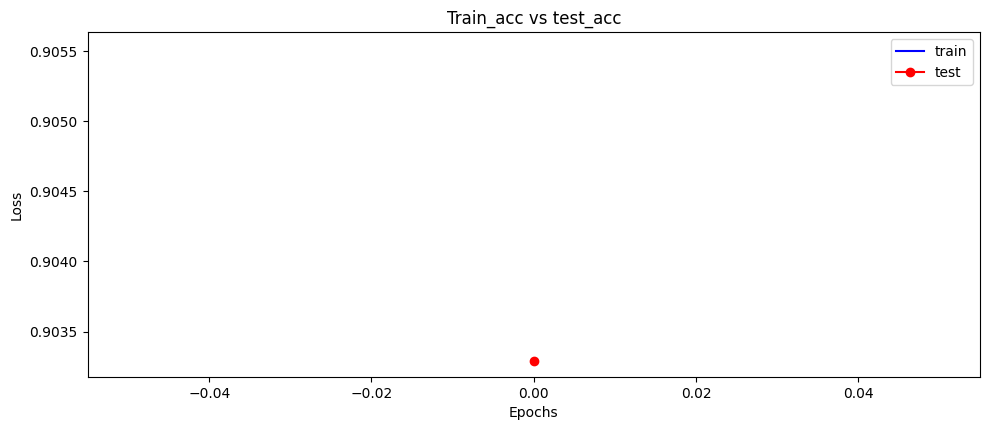

=========> Epoch 1 | Train Loss: 529.2608578950167 Train acc: 0.906 | Test acc: 0.903


100%|██████████| 1875/1875 [07:12<00:00,  4.34it/s]


Epoch 2: avg improved to 0.280.
Checkpoint saved at /content/drive/My Drive/checkpoint_epoch_2.pth


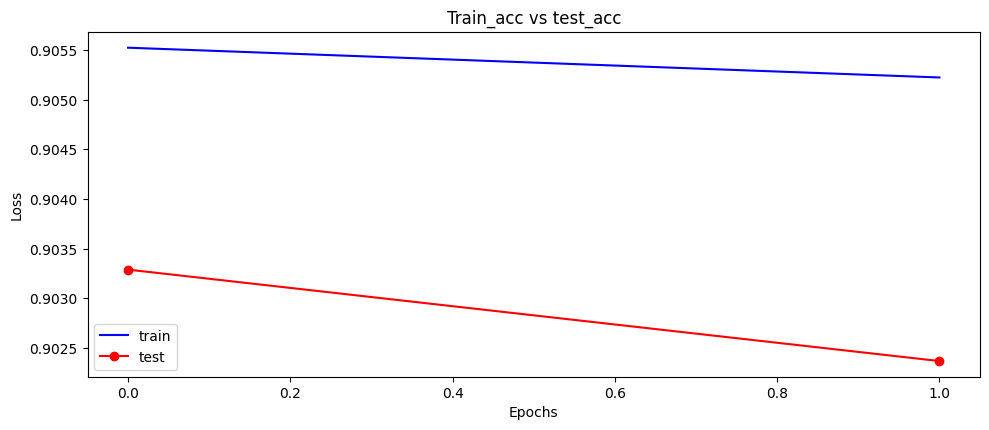

=========> Epoch 2 | Train Loss: 524.3218406885862 Train acc: 0.905 | Test acc: 0.902


100%|██████████| 1875/1875 [07:15<00:00,  4.31it/s]


Epoch 3: avg improved to 0.277.
Checkpoint saved at /content/drive/My Drive/checkpoint_epoch_3.pth


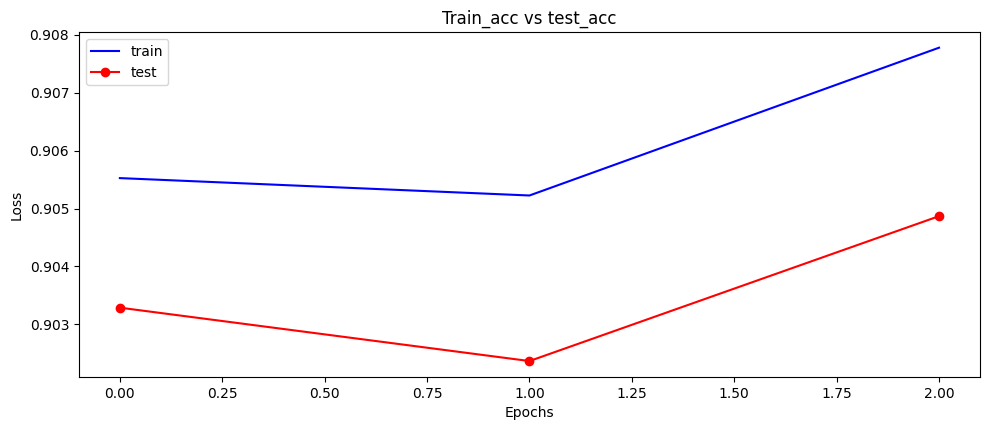

=========> Epoch 3 | Train Loss: 520.1465946212411 Train acc: 0.908 | Test acc: 0.905


100%|██████████| 1875/1875 [07:13<00:00,  4.32it/s]


Epoch 4: avg improved to 0.276.
Checkpoint saved at /content/drive/My Drive/checkpoint_epoch_4.pth


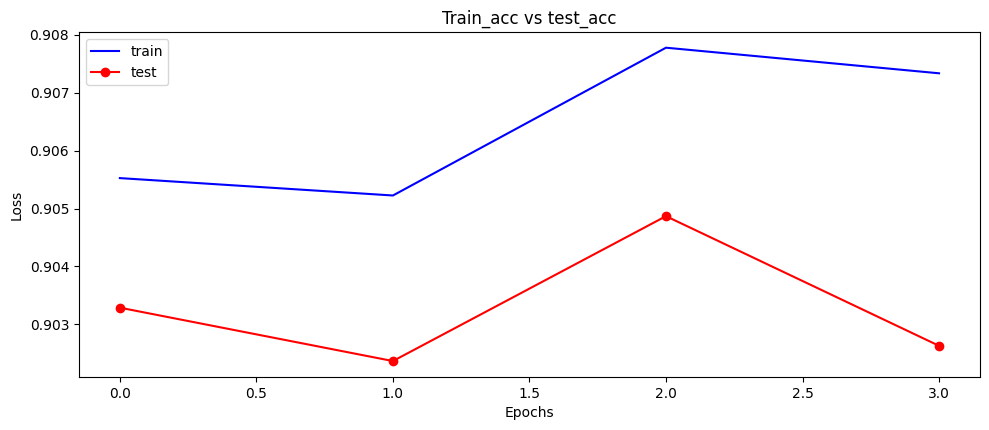

=========> Epoch 4 | Train Loss: 517.9111368060112 Train acc: 0.907 | Test acc: 0.903


100%|██████████| 1875/1875 [07:12<00:00,  4.33it/s]


Epoch 5: avg improved to 0.275.
Checkpoint saved at /content/drive/My Drive/checkpoint_epoch_5.pth


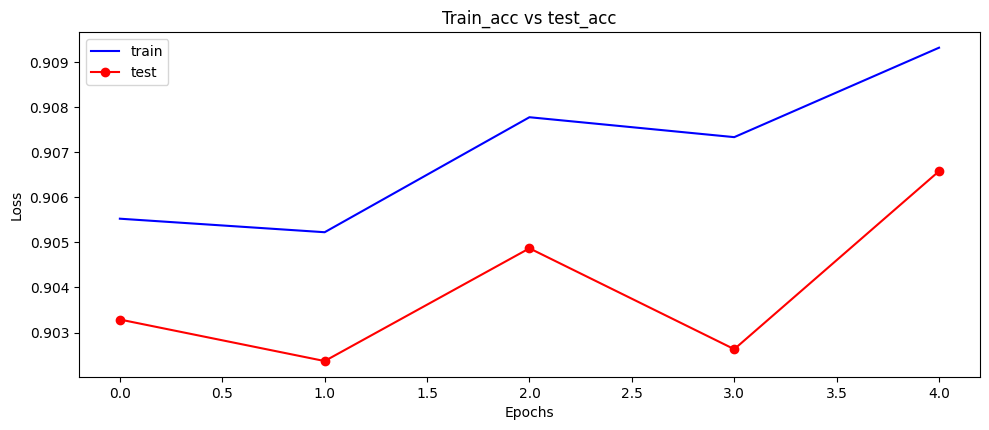

=========> Epoch 5 | Train Loss: 515.254856184125 Train acc: 0.909 | Test acc: 0.907


100%|██████████| 1875/1875 [07:16<00:00,  4.30it/s]


Epoch 6: avg improved to 0.274.
Checkpoint saved at /content/drive/My Drive/checkpoint_epoch_6.pth


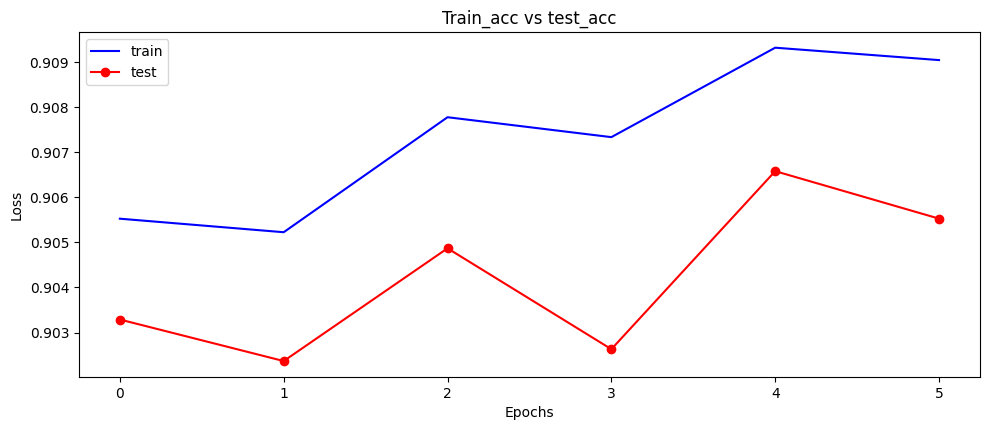

=========> Epoch 6 | Train Loss: 514.093792360276 Train acc: 0.909 | Test acc: 0.906


100%|██████████| 1875/1875 [07:15<00:00,  4.31it/s]


Epoch 7: Loss did not improve for 1 consecutive epochs.
Checkpoint saved at /content/drive/My Drive/checkpoint_epoch_7.pth


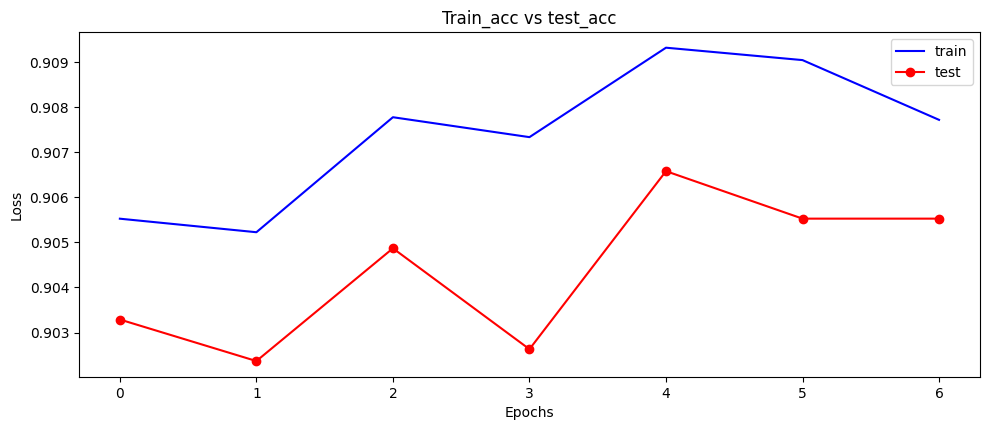

=========> Epoch 7 | Train Loss: 516.1213350147009 Train acc: 0.908 | Test acc: 0.906


100%|██████████| 1875/1875 [07:14<00:00,  4.31it/s]


Epoch 8: avg improved to 0.273.
Checkpoint saved at /content/drive/My Drive/checkpoint_epoch_8.pth


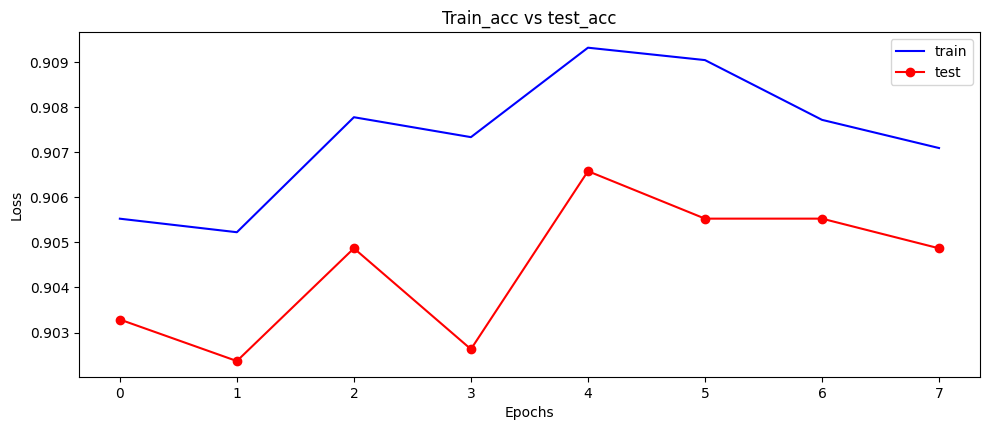

=========> Epoch 8 | Train Loss: 511.2015969231725 Train acc: 0.907 | Test acc: 0.905


100%|██████████| 1875/1875 [07:15<00:00,  4.30it/s]


Epoch 9: avg improved to 0.272.
Checkpoint saved at /content/drive/My Drive/checkpoint_epoch_9.pth


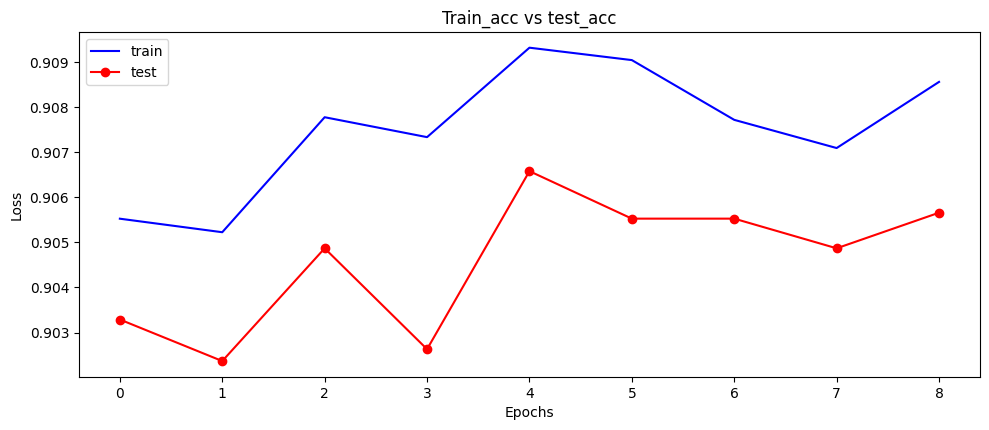

=========> Epoch 9 | Train Loss: 510.20277220755816 Train acc: 0.909 | Test acc: 0.906


100%|██████████| 1875/1875 [07:17<00:00,  4.29it/s]


Epoch 10: Loss did not improve for 1 consecutive epochs.
Checkpoint saved at /content/drive/My Drive/checkpoint_epoch_10.pth


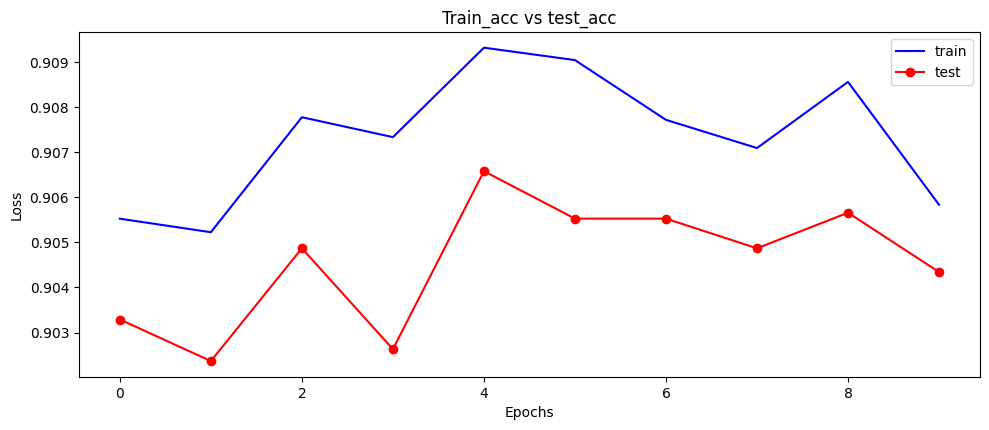

=========> Epoch 10 | Train Loss: 511.80821366608143 Train acc: 0.906 | Test acc: 0.904


In [ ]:
from torch.optim import Adam
from tqdm import tqdm


lr = 0.001
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()

optimizer = Adam(model.parameters(), lr=lr)
n_epochs = 10

best_loss = float('inf')
patience = 3
train_losses = []
train_accs = []
test_accs = []

for epoch in range(n_epochs):
  total_loss = 0.
  model.train()
  for data in tqdm(train_loader):
    model.zero_grad()
    inputs, attention_mask, labels = data
    inputs, attention_mask, labels = inputs.to(device), attention_mask.to(device), labels.to(device)

    preds = model(inputs, attention_mask)
    loss = loss_fn(preds, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
  avg_loss = total_loss / len(train_loader)
  train_losses.append(avg_loss)

    # 손실 감소 여부 확인 및 로그 출력
  if avg_loss < best_loss:
      best_loss = avg_loss
      counter = 0
      print(f"Epoch {epoch + 1}: avg improved to {avg_loss:.3f}.")
  else:
      counter += 1
      print(f"Epoch {epoch + 1}: Loss did not improve for {counter} consecutive epochs.")

  # Patience 초과 시 로그 출력 후 학습 중단
  if counter >= patience:
      print(f"Stopping early at epoch {epoch + 1}. Best Loss: {best_loss:.3f}")
      break

  if epoch % 1 == 0:
    # 학습 상태 저장
    save_path = f"/content/drive/My Drive/checkpoint_epoch_{epoch + 1}.pth"
    save_checkpoint(epoch + 1, model, optimizer, best_loss, counter, train_losses, train_accs, test_accs, save_path)


  model.eval()
  with torch.no_grad():
      train_acc = accuracy(model, train_loader)
      test_acc = accuracy(model, test_loader)
      train_accs.append(train_acc)
      test_accs.append(test_acc)
      live_plot(train_accs, test_accs)
      print(f"=========> Epoch {epoch + 1} | Train Loss: {total_loss} Train acc: {train_acc:.3f} | Test acc: {test_acc:.3f}")


In [ ]:
import os
import time

print("학습이 완료되었습니다. 세션을 종료합니다.")
time.sleep(5)  # 5초 대기 (필요하면 대기 시간을 조정하세요)
os._exit(0)  # Colab 세션 종료

학습이 완료되었습니다. 세션을 종료합니다.
